In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:

# Feel free to change these and experiment !!
use_ln = False
use_bn = False
batch_size = 64
norm = "NoNorm"

num_epochs = 20
num_classes = 10
model_arch = "custom"
lr = 0.001
momentum = 0.9

NUM_BATCHES_TO_LOG = 10 
NUM_IMAGES_PER_BATCH = 32
L1_SIZE = 32
L2_SIZE = 64
CONV_KERNEL_SIZE = 5

#### MNIST Dataset

In [3]:
# create train and test sets
train_set = MNIST('./', download=True,
            transform=transforms.Compose([transforms.ToTensor(),]),
            train=True)

test_set = MNIST('./', download=True,
           transform=transforms.Compose([transforms.ToTensor(),]),
           train=False)


train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False)

numbers = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

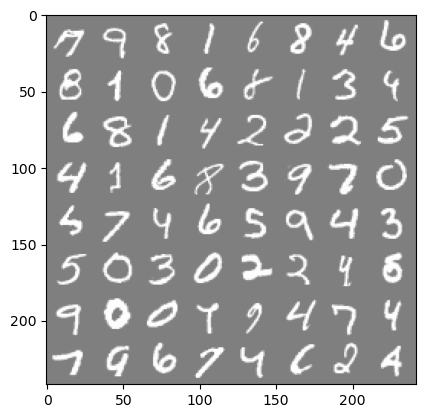

7     9     8     1     6     8     4     6     8     1     0     6     8     1     3     4     6     8     1     4     2     2     2     5     4     1     6     8     3     9     7     0     5     7     4     6     5     9     4     3     5     0     3     0     2     2     4     5     9     0     0     7     9     4     7     4     7     9     6     7     4     6     2     4    


In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{numbers[labels[j]]:5s}' for j in range(batch_size)))

### CIFAR10 Dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader1 = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader1 = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


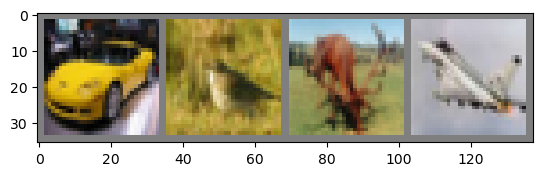

car   bird  deer  plane


In [6]:
# get some random training images
dataiter = iter(train_loader1)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
## BatchNorm reimplementation
class myBatchNorm2d(nn.Module):
    def __init__(self, input_size = None , eps = 1e-3, momentum = 0.99):
        super(myBatchNorm2d, self).__init__()
        assert input_size, print('Missing input_size parameter.')
        
        # Batch mean & var must be defined during training
        self.mu = torch.zeros(1, input_size)
        self.var = torch.ones(1, input_size)
        
        # For numerical stability
        self.eps = eps
        
        # Exponential moving average for mu & var update 
        self.it_call = 0  # training iterations
        self.momentum = momentum # EMA smoothing
        
        # Trainable parameters
        self.beta = torch.nn.Parameter(torch.zeros(1, input_size))
        self.gamma = torch.nn.Parameter(torch.ones(1, input_size))
        
        # Batch size on which the normalization is computed
        self.batch_size = 0

        
    def forward(self, x):
        # [batch_size, input_size]
        
        self.it_call += 1
        
        if self.training :
            
            if( self.batch_size == 0 ):
                # First iteration : save batch_size
                self.batch_size = x.shape[0]
            
            # Training : compute BN pass
            batch_mu = (x.sum(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            batch_var = (x.var(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            
            x_normalized = (x-batch_mu)/torch.sqrt(batch_var + self.eps) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
            
            
            # Update mu & std 
            if(x.shape[0] == self.batch_size):
                running_mu = batch_mu
                running_var = batch_var
            else:
                running_mu = batch_mu*self.batch_size/x.shape[0]
                running_var = batch_var*self.batch_size/x.shape[0]
 
            self.mu = running_mu * (self.momentum/self.it_call) + \
                            self.mu * (1 - (self.momentum/self.it_call))
            self.var = running_var * (self.momentum/self.it_call) + \
                        self.var * (1 - (self.momentum/self.it_call))
            
        else:
            # Inference : compute BN pass using estimated mu & var
            if (x.shape[0] == self.batch_size):
                estimated_mu = self.mu
                estimated_var = self.var
            else :
                estimated_mu = self.mu*x.shape[0]/self.batch_size
                estimated_var = self.var*x.shape[0]/self.batch_size
                
            x_normalized = (x-estimated_mu)/torch.sqrt(estimated_var + self.eps) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
    
        return x_bn # [batch_size, output_size=input_size]


In [8]:
# Define a custom Layer Normalization layer
class MyLayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-3):
        super(MyLayerNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps

        # Parameters for Layer Normalization
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        # Compute Layer Norm
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True, unbiased=False)
        x = (x - mean) / (std + self.eps)
        
        # Apply scale and shift
        x_ln = x * self.gamma[None, :] + self.beta[None, :]
        return x_ln

#### CNN - baseline

In [9]:
class ConvNet_baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_baseline, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using pytorch's LayerNorm

In [10]:
class ConvNet_torch_layer(nn.Module):
    def __init__(self, num_classes=10, use_ln: bool = use_ln):
        super(ConvNet_torch_layer, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.LayerNorm([L1_SIZE, 28, 28]) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.LayerNorm([L2_SIZE, 14, 14]) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using myLayerNorm

In [11]:

class ConvNet_my_layer(nn.Module):
    def __init__(self, num_classes=10, use_ln: bool = use_ln):
        super(ConvNet_my_layer, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myLayerNorm(L1_SIZE) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myLayerNorm(L2_SIZE) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


#### CNN using myBatchNorm2d

In [12]:
class ConvNet_my_batch(nn.Module):
    def __init__(self, num_classes=10, use_bn: bool = use_bn):
        super(ConvNet_my_batch, self).__init__()
        self.use_bn = use_bn
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myBatchNorm2d(L1_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myBatchNorm2d(L2_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using pytorch's BatchNorm

In [13]:
class ConvNet_torch_batch(nn.Module):
    def __init__(self, num_classes=10, use_bn: bool = use_bn):
        super(ConvNet_torch_batch, self).__init__()
        self.use_bn = use_bn
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.BatchNorm2d(L1_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.BatchNorm2d(L2_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
# convenience funtion to log predictions for a batch of test images
def log_test_predictions(images, labels, outputs, predicted, test_table, log_counter):
  # obtain confidence scores for all classes
  scores = F.softmax(outputs.data, dim=1)
  log_scores = scores.cpu().numpy()
  log_images = images.cpu().numpy()
  log_labels = labels.cpu().numpy()
  log_preds = predicted.cpu().numpy()
  # adding ids based on the order of the images
  _id = 0
  for i, l, p, s in zip(log_images, log_labels, log_preds, log_scores):
    # add required info to data table:
    # id, image pixels, model's guess, true label, scores for all classes
    img_id = str(_id) + "_" + str(log_counter)
    test_table.add_data(img_id, wandb.Image(i), p, l, *s)
    _id += 1
    if _id == NUM_IMAGES_PER_BATCH:
      break

In [15]:
net = ConvNet_baseline(num_classes).to(device)
net1 = ConvNet_torch_layer(num_classes, use_ln).to(device)
net2 = ConvNet_torch_batch(num_classes, use_bn).to(device)
net3 = ConvNet_my_layer(num_classes, use_ln).to(device)
net4 = ConvNet_my_batch(num_classes, use_bn).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
optimizer1 = optim.SGD(net1.parameters(), lr = lr, momentum = momentum)
optimizer2 = optim.SGD(net2.parameters(), lr = lr, momentum = momentum)
optimizer3 = optim.SGD(net3.parameters(), lr = lr, momentum = momentum)
optimizer4 = optim.SGD(net4.parameters(), lr = lr, momentum = momentum)




### Training - Baseline model on MNIST dataset

In [16]:
# train the model
total_step = len(train_loader)
accu = []
Loss = []

for epoch in range(num_epochs):
    # training step
    total_loss = 0
    total_Loss=0


    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = net(images)

        loss = criterion(outputs, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()    

    if epoch%10==0:
        print(epoch,loss.item())


    # ✨ W&B: Create a Table to store predictions for each test step
    columns=["id", "image", "guess", "truth"]
    for digit in range(10):
      columns.append("score_" + str(digit))

    # test the model
    net.eval()
    log_counter = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)

            loss_t = criterion(outputs, labels)
            total_Loss += loss_t.item() 

            _, predicted = torch.max(outputs.data, 1)

            
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        accu.append(acc)
        Loss.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the baseline model on the 10000 test images: {} % \n'.format(acc))


0 0.24739021062850952
Test Accuracy of the baseline model on the 10000 test images: 93.24 % 

Test Accuracy of the baseline model on the 10000 test images: 95.84 % 

Test Accuracy of the baseline model on the 10000 test images: 97.02 % 

Test Accuracy of the baseline model on the 10000 test images: 97.3 % 

Test Accuracy of the baseline model on the 10000 test images: 97.5 % 

Test Accuracy of the baseline model on the 10000 test images: 98.13 % 

Test Accuracy of the baseline model on the 10000 test images: 98.26 % 

Test Accuracy of the baseline model on the 10000 test images: 98.2 % 

Test Accuracy of the baseline model on the 10000 test images: 98.26 % 

Test Accuracy of the baseline model on the 10000 test images: 98.2 % 

10 0.011745539493858814
Test Accuracy of the baseline model on the 10000 test images: 98.2 % 

Test Accuracy of the baseline model on the 10000 test images: 98.6 % 

Test Accuracy of the baseline model on the 10000 test images: 98.48 % 

Test Accuracy of the bas

In [17]:
print(Loss)
print(accu)

[36.58402459323406, 22.722304702736437, 16.644548141164705, 14.40497350716032, 12.039341597934254, 10.143897058384027, 8.9667783768964, 8.682898981525796, 8.130732384859584, 8.683987311669625, 7.936908285249956, 6.603618170891423, 7.068882216495695, 6.422900004792609, 6.412202077743132, 5.692053141683573, 6.153669307619566, 6.175032347135129, 5.938487246778095, 5.429238554192125]
[93.24, 95.84, 97.02, 97.3, 97.5, 98.13, 98.26, 98.2, 98.26, 98.2, 98.2, 98.6, 98.48, 98.6, 98.6, 98.87, 98.6, 98.77, 98.68, 98.79]


### Training - CNN model with pytorch layernorm on MNIST dataset

In [18]:

# train the model
total_step = len(train_loader)
accu1 = []
Loss1 = []

for epoch in range(num_epochs):
    # training step
    total_loss1 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs1 = net1(images)

        loss1 = criterion(outputs1, labels)
        # backward and optimize
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        total_loss1 += loss1.item()    

    if epoch%10==0:
        print(epoch,loss1.item())


    # ✨ W&B: Create a Table to store predictions for each test step
    columns=["id", "image", "guess", "truth"]
    for digit in range(10):
      columns.append("score_" + str(digit))

    # test the model
    net1.eval()
    log_counter = 0
    with torch.no_grad():
        correct1 = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs1 = net1(images)
            
            loss_t = criterion(outputs1, labels)
            total_Loss += loss_t.item() 


            _, predicted1 = torch.max(outputs1.data, 1)

            
            total += labels.size(0)

            correct1 += (predicted1 == labels).sum().item()

        acc1 = 100 * correct1 / total
        accu1.append(acc1)
        Loss1.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the pytorch layer model on the 10000 test images: {} % \n'.format(acc1))
        


0 0.25016915798187256
Test Accuracy of the pytorch layer model on the 10000 test images: 93.06 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 95.73 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 96.73 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 97.31 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 97.76 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 97.98 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 97.85 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 98.19 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 98.4 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 98.44 % 

10 0.02803332358598709
Test Accuracy of the pytorch layer model on the 10000 test images: 98.51 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 98.57 % 

Test Accuracy of the pytorch lay

### Training - CNN model with pytorch batchnorm on MNIST dataset

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader)
accu2 = []
Loss2 = []

for epoch in range(num_epochs):
    # training step
    total_loss2 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs2 = net2(images)

        loss2 = criterion(outputs2, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss2.backward()
        optimizer.step()
  
        total_loss2 += loss2.item()       

    if epoch%10==0:
        print(epoch,loss2.item())


    # ✨ W&B: Create a Table to store predictions for each test step
    columns=["id", "image", "guess", "truth"]
    for digit in range(10):
      columns.append("score_" + str(digit))

    # test the model
    net2.eval()
    log_counter = 0
    with torch.no_grad():
        correct2 = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs2 = net2(images)
            loss_t = criterion(outputs2, labels)
            total_Loss += loss_t.item() 


            _, predicted2 = torch.max(outputs2.data, 1)

            
            total += labels.size(0)

            correct2 += (predicted2 == labels).sum().item()

        acc2 = 100 * correct2 / total
        accu2.append(acc2)
        Loss2.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the pytorch batch model on the 10000 test images: {} % \n'.format(acc2))


0 0.1339920610189438
Test Accuracy of the pytorch batch model on the 10000 test images: 93.5 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 95.8 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 96.51 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 97.14 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 97.93 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.19 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.25 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.38 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.28 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.51 % 

10 0.007448533549904823
Test Accuracy of the pytorch batch model on the 10000 test images: 98.72 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 98.64 % 

Test Accuracy of the pytorch batc

### Training - CNN model with user-defined layernorm on MNIST dataset

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader)
accu3 = []
Loss3 = []

for epoch in range(num_epochs):
    # training step
    total_loss3 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs3 = net3(images)

        loss3 = criterion(outputs3, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss3.backward()
        optimizer.step()
 
        total_loss3 += loss3.item()      

    if epoch%10==0:
        print(epoch,loss3.item())


    # ✨ W&B: Create a Table to store predictions for each test step
    columns=["id", "image", "guess", "truth"]
    for digit in range(10):
      columns.append("score_" + str(digit))

    # test the model
    net3.eval()
    log_counter = 0
    with torch.no_grad():
        correct3 = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs3 = net3(images)

            loss_t = criterion(outputs3, labels)
            total_Loss += loss_t.item() 


            _, predicted3 = torch.max(outputs3.data, 1)

            
            total += labels.size(0)

            correct3 += (predicted3 == labels).sum().item()

        acc3 = 100 * correct3 / total
        accu3.append(acc3)
        Loss3.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the my batch model on the 10000 test images: {} % \n'.format(acc3))


0 0.14991971850395203
Test Accuracy of the my batch model on the 10000 test images: 93.36 % 

Test Accuracy of the my batch model on the 10000 test images: 95.91 % 

Test Accuracy of the my batch model on the 10000 test images: 96.9 % 

Test Accuracy of the my batch model on the 10000 test images: 97.42 % 

Test Accuracy of the my batch model on the 10000 test images: 97.76 % 

Test Accuracy of the my batch model on the 10000 test images: 98.04 % 

Test Accuracy of the my batch model on the 10000 test images: 98.21 % 

Test Accuracy of the my batch model on the 10000 test images: 98.37 % 

Test Accuracy of the my batch model on the 10000 test images: 98.35 % 

Test Accuracy of the my batch model on the 10000 test images: 98.47 % 

10 0.10914044082164764
Test Accuracy of the my batch model on the 10000 test images: 98.59 % 

Test Accuracy of the my batch model on the 10000 test images: 98.55 % 

Test Accuracy of the my batch model on the 10000 test images: 98.54 % 

Test Accuracy of the

### Training - CNN model with user-defined batchnorm on MNIST dataset

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader)
accu4 = []
Loss4 = []

for epoch in range(num_epochs):
    # training step
    total_loss4 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs4 = net4(images)

        loss4 = criterion(outputs4, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss4.backward()
        optimizer.step()
 
        total_loss4 += loss4.item()      

    if epoch%10==0:
        print(epoch,loss4.item())


    # ✨ W&B: Create a Table to store predictions for each test step
    columns=["id", "image", "guess", "truth"]
    for digit in range(10):
      columns.append("score_" + str(digit))

    # test the model
    net4.eval()
    log_counter = 0
    with torch.no_grad():
        correct4 = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs4 = net4(images)

            loss_t = criterion(outputs4, labels)
            total_Loss += loss_t.item() 


            _, predicted4 = torch.max(outputs4.data, 1)

            
            total += labels.size(0)

            correct4 += (predicted4 == labels).sum().item()

        acc4 = 100 * correct4 / total
        accu4.append(acc4)
        Loss4.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the my batch model on the 10000 test images: {} % \n'.format(acc4))


0 0.24672384560108185
Test Accuracy of the my batch model on the 10000 test images: 93.37 % 

Test Accuracy of the my batch model on the 10000 test images: 95.61 % 

Test Accuracy of the my batch model on the 10000 test images: 96.82 % 

Test Accuracy of the my batch model on the 10000 test images: 97.43 % 

Test Accuracy of the my batch model on the 10000 test images: 97.85 % 

Test Accuracy of the my batch model on the 10000 test images: 97.96 % 

Test Accuracy of the my batch model on the 10000 test images: 98.09 % 

Test Accuracy of the my batch model on the 10000 test images: 98.26 % 

Test Accuracy of the my batch model on the 10000 test images: 98.44 % 

Test Accuracy of the my batch model on the 10000 test images: 98.47 % 

10 0.012467295862734318
Test Accuracy of the my batch model on the 10000 test images: 98.58 % 

Test Accuracy of the my batch model on the 10000 test images: 98.57 % 

Test Accuracy of the my batch model on the 10000 test images: 98.47 % 

Test Accuracy of t

In [22]:
print(accu4)


[93.37, 95.61, 96.82, 97.43, 97.85, 97.96, 98.09, 98.26, 98.44, 98.47, 98.58, 98.57, 98.47, 98.73, 98.53, 98.6, 98.61, 98.62, 98.72, 98.84]


#### CNN - baseline - CIFAR10

In [23]:
class ConvNet_baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_baseline, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using pytorch's LayerNorm - CIFAR10

In [24]:
class ConvNet_torch_layer(nn.Module):
    def __init__(self, num_classes=10, use_ln: bool = use_ln):
        super(ConvNet_torch_layer, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.LayerNorm([L1_SIZE, 28, 28]) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.LayerNorm([L2_SIZE, 14, 14]) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using myLayerNorm - CIFAR10

In [25]:

class ConvNet_my_layer(nn.Module):
    def __init__(self, num_classes=10, use_ln: bool = use_ln):
        super(ConvNet_my_layer, self).__init__()
        self.use_ln = use_ln
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myLayerNorm(L1_SIZE) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myLayerNorm(L2_SIZE) if self.use_ln else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


#### CNN using myBatchNorm2d - CIFAR10

In [26]:
class ConvNet_my_batch(nn.Module):
    def __init__(self, num_classes=10, use_bn: bool = use_bn):
        super(ConvNet_my_batch, self).__init__()
        self.use_bn = use_bn
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myBatchNorm2d(L1_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.myBatchNorm2d(L2_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### CNN using pytorch's BatchNorm - CIFAR10

In [27]:
class ConvNet_torch_batch(nn.Module):
    def __init__(self, num_classes=10, use_bn: bool = use_bn):
        super(ConvNet_torch_batch, self).__init__()
        self.use_bn = use_bn
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, L1_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.BatchNorm2d(L1_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(L1_SIZE, L2_SIZE, CONV_KERNEL_SIZE, stride=1, padding=2),
            nn.BatchNorm2d(L2_SIZE) if self.use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64*L2_SIZE, num_classes)
        self.softmax = nn.Softmax(num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [28]:
net_Cifar = ConvNet_baseline(num_classes).to(device)
net1_Cifar = ConvNet_torch_layer(num_classes, use_ln).to(device)
net2_Cifar = ConvNet_torch_batch(num_classes, use_bn).to(device)
net3_Cifar = ConvNet_my_layer(num_classes, use_ln).to(device)
net4_Cifar = ConvNet_my_batch(num_classes, use_bn).to(device)

### Training - Baseline model on CIFAR dataset

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_Cifar.parameters(), lr = lr, momentum = momentum)

# train the model
total_step = len(train_loader1)
accu_cifar = []
Loss_cifar = []

for epoch in range(num_epochs):
    # training step
    total_loss = 0
    total_Loss=0


    for i, (images, labels) in enumerate(train_loader1):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = net_Cifar(images)

        loss = criterion(outputs, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()    

    if epoch%10==0:
        print(epoch,loss.item())

    # test the model
    net_Cifar.eval()
    log_counter = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader1:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net_Cifar(images)

            loss_t = criterion(outputs, labels)
            total_Loss += loss_t.item() 

            _, predicted = torch.max(outputs.data, 1)

            
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        accu_cifar.append(acc)
        Loss_cifar.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the baseline model on the 10000 test images: {} % \n'.format(acc))


0 1.6620813608169556
Test Accuracy of the baseline model on the 10000 test images: 63.89 % 

Test Accuracy of the baseline model on the 10000 test images: 68.19 % 

Test Accuracy of the baseline model on the 10000 test images: 69.38 % 

Test Accuracy of the baseline model on the 10000 test images: 71.0 % 

Test Accuracy of the baseline model on the 10000 test images: 71.75 % 

Test Accuracy of the baseline model on the 10000 test images: 70.05 % 

Test Accuracy of the baseline model on the 10000 test images: 70.2 % 

Test Accuracy of the baseline model on the 10000 test images: 70.45 % 

Test Accuracy of the baseline model on the 10000 test images: 70.76 % 

Test Accuracy of the baseline model on the 10000 test images: 69.12 % 

10 0.5224687457084656
Test Accuracy of the baseline model on the 10000 test images: 69.79 % 

Test Accuracy of the baseline model on the 10000 test images: 69.67 % 

Test Accuracy of the baseline model on the 10000 test images: 69.88 % 

Test Accuracy of the ba

### Training - CNN model with pytorch layernorm on CIFAR dataset

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1_Cifar.parameters(), lr = lr, momentum = momentum)

# train the model
total_step = len(train_loader1)
accu1_cifar = []
Loss1_cifar = []

for epoch in range(num_epochs):
    # training step
    total_loss1 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader1):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs1 = net1_Cifar(images)

        loss1 = criterion(outputs1, labels)
        # backward and optimize
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        total_loss1 += loss1.item()    

    if epoch%10==0:
        print(epoch,loss1.item())



    # test the model
    net1_Cifar.eval()
    log_counter = 0
    with torch.no_grad():
        correct1 = 0
        total = 0
        for images, labels in test_loader1:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs1 = net1_Cifar(images)
            
            loss_t = criterion(outputs1, labels)
            total_Loss += loss_t.item() 


            _, predicted1 = torch.max(outputs1.data, 1)

            
            total += labels.size(0)

            correct1 += (predicted1 == labels).sum().item()

        acc1 = 100 * correct1 / total
        accu1_cifar.append(acc1)
        Loss1_cifar.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the pytorch layer model on the 10000 test images: {} % \n'.format(acc1))
        


0 1.7113415002822876
Test Accuracy of the pytorch layer model on the 10000 test images: 58.7 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 67.7 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 70.29 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 71.78 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 71.29 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 70.89 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 69.88 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 70.74 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 70.89 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 70.83 % 

10 0.42292335629463196
Test Accuracy of the pytorch layer model on the 10000 test images: 69.87 % 

Test Accuracy of the pytorch layer model on the 10000 test images: 69.69 % 

Test Accuracy of the pytorch layer

### Training - CNN model with pytorch batchnorm on CIFAR dataset

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2_Cifar.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader1)
accu2_cifar = []
Loss2_cifar = []

for epoch in range(num_epochs):
    # training step
    total_loss2 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader1):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs2 = net2_Cifar(images)

        loss2 = criterion(outputs2, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss2.backward()
        optimizer.step()
  
        total_loss2 += loss2.item()       

    if epoch%10==0:
        print(epoch,loss2.item())



    # test the model
    net2_Cifar.eval()
    log_counter = 0
    with torch.no_grad():
        correct2 = 0
        total = 0
        for images, labels in test_loader1:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs2 = net2_Cifar(images)
            loss_t = criterion(outputs2, labels)
            total_Loss += loss_t.item() 


            _, predicted2 = torch.max(outputs2.data, 1)

            
            total += labels.size(0)

            correct2 += (predicted2 == labels).sum().item()

        acc2 = 100 * correct2 / total
        accu2_cifar.append(acc2)
        Loss2_cifar.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the pytorch batch model on the 10000 test images: {} % \n'.format(acc2))


0 1.2360714673995972
Test Accuracy of the pytorch batch model on the 10000 test images: 61.97 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 67.37 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 70.65 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 69.94 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 71.49 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 70.17 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 71.23 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 71.2 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 71.25 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 70.43 % 

10 0.9193922281265259
Test Accuracy of the pytorch batch model on the 10000 test images: 70.35 % 

Test Accuracy of the pytorch batch model on the 10000 test images: 69.59 % 

Test Accuracy of the pytorch batch

### Training - CNN model with user-defined layernorm on CIFAR dataset

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3_Cifar.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader1)
accu3_cifar = []
Loss3_cifar = []

for epoch in range(num_epochs):
    # training step
    total_loss3 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader1):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs3 = net3_Cifar(images)

        loss3 = criterion(outputs3, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss3.backward()
        optimizer.step()
 
        total_loss3 += loss3.item()      

    if epoch%10==0:
        print(epoch,loss3.item())



    # test the model
    net3_Cifar.eval()
    log_counter = 0
    with torch.no_grad():
        correct3 = 0
        total = 0
        for images, labels in test_loader1:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs3 = net3_Cifar(images)

            loss_t = criterion(outputs3, labels)
            total_Loss += loss_t.item() 


            _, predicted3 = torch.max(outputs3.data, 1)

            
            total += labels.size(0)

            correct3 += (predicted3 == labels).sum().item()

        acc3 = 100 * correct3 / total
        accu3_cifar.append(acc3)
        Loss3_cifar.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the my batch model on the 10000 test images: {} % \n'.format(acc3))


0 0.49795451760292053


Test Accuracy of the my batch model on the 10000 test images: 61.43 % 

Test Accuracy of the my batch model on the 10000 test images: 68.43 % 

Test Accuracy of the my batch model on the 10000 test images: 68.32 % 

Test Accuracy of the my batch model on the 10000 test images: 70.26 % 

Test Accuracy of the my batch model on the 10000 test images: 69.62 % 

Test Accuracy of the my batch model on the 10000 test images: 71.74 % 

Test Accuracy of the my batch model on the 10000 test images: 69.99 % 

Test Accuracy of the my batch model on the 10000 test images: 70.75 % 

Test Accuracy of the my batch model on the 10000 test images: 69.94 % 

Test Accuracy of the my batch model on the 10000 test images: 69.45 % 

10 0.04275773465633392
Test Accuracy of the my batch model on the 10000 test images: 68.73 % 

Test Accuracy of the my batch model on the 10000 test images: 68.78 % 

Test Accuracy of the my batch model on the 10000 test images: 69.48 % 

Test Accuracy of the my batch model on th

### Training - CNN model with user-defined batchnorm on CIFAR dataset

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4_Cifar.parameters(), lr = lr, momentum = momentum)


# train the model
total_step = len(train_loader1)
accu4_cifar = []
Loss4_cifar = []

for epoch in range(num_epochs):
    # training step
    total_loss4 = 0
    total_Loss=0

    for i, (images, labels) in enumerate(train_loader1):
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs4 = net4_Cifar(images)

        loss4 = criterion(outputs4, labels)
        # backward and optimize
        optimizer.zero_grad()
        loss4.backward()
        optimizer.step()
 
        total_loss4 += loss4.item()      

    if epoch%10==0:
        print(epoch,loss4.item())



    # test the model
    net4_Cifar.eval()
    log_counter = 0
    with torch.no_grad():
        correct4 = 0
        total = 0
        for images, labels in test_loader1:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs4 = net4_Cifar(images)

            loss_t = criterion(outputs4, labels)
            total_Loss += loss_t.item() 


            _, predicted4 = torch.max(outputs4.data, 1)

            
            total += labels.size(0)

            correct4 += (predicted4 == labels).sum().item()

        acc4 = 100 * correct4 / total
        accu4_cifar.append(acc4)
        Loss4_cifar.append(total_Loss)
        #if epoch%10==0:
        #  print(epoch,"acc" : acc)
        
        print('Test Accuracy of the my batch model on the 10000 test images: {} % \n'.format(acc4))


0 0.8558929562568665
Test Accuracy of the my batch model on the 10000 test images: 61.31 % 

Test Accuracy of the my batch model on the 10000 test images: 69.66 % 

Test Accuracy of the my batch model on the 10000 test images: 69.64 % 

Test Accuracy of the my batch model on the 10000 test images: 70.86 % 

Test Accuracy of the my batch model on the 10000 test images: 71.93 % 

Test Accuracy of the my batch model on the 10000 test images: 71.05 % 

Test Accuracy of the my batch model on the 10000 test images: 71.2 % 

Test Accuracy of the my batch model on the 10000 test images: 71.15 % 

Test Accuracy of the my batch model on the 10000 test images: 71.15 % 

Test Accuracy of the my batch model on the 10000 test images: 70.2 % 

10 1.33735191822052
Test Accuracy of the my batch model on the 10000 test images: 69.88 % 

Test Accuracy of the my batch model on the 10000 test images: 70.14 % 

Test Accuracy of the my batch model on the 10000 test images: 70.02 % 

Test Accuracy of the my b

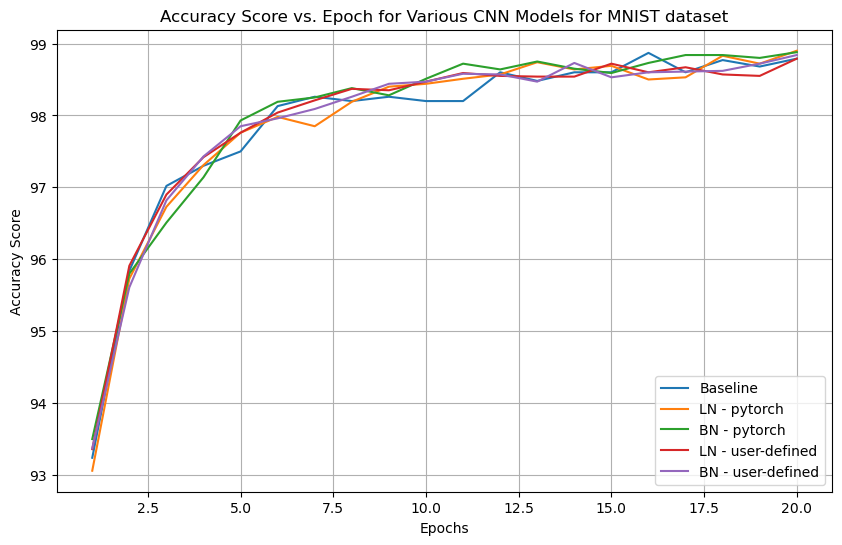

In [34]:

# Define the data for various models
model_names = ["Baseline", "LN - pytorch", "BN - pytorch", "LN - user-defined", "BN - user-defined"]
epochs = my_list = [i for i in range(1, num_epochs+1)] # Replace with your actual epochs

# Plot accuracy scores vs. epochs for each model
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot Model A
plt.plot(epochs, accu, label=model_names[0])

# Plot Model B
plt.plot(epochs, accu1, label=model_names[1])

# Plot Model C
plt.plot(epochs, accu2, label=model_names[2])

# Plot Model C
plt.plot(epochs, accu3, label=model_names[3])

# Plot Model C
plt.plot(epochs, accu4, label=model_names[4])

plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs. Epoch for Various CNN Models for MNIST dataset")
plt.legend(loc="lower right")  # Adjust the legend position as needed

plt.grid(True)
plt.show()


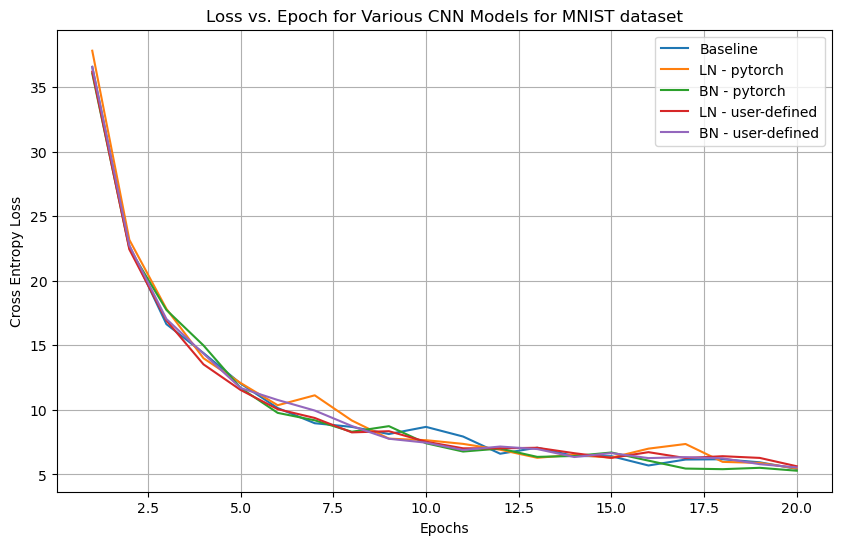

In [35]:
# Plot accuracy scores vs. epochs for each model
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot Model A
plt.plot(epochs, Loss, label=model_names[0])

# Plot Model B
plt.plot(epochs, Loss1, label=model_names[1])

# Plot Model C
plt.plot(epochs, Loss2, label=model_names[2])

# Plot Model C
plt.plot(epochs, Loss3, label=model_names[3])

# Plot Model C
plt.plot(epochs, Loss4, label=model_names[4])

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss vs. Epoch for Various CNN Models for MNIST dataset")
plt.legend(loc="upper right")  # Adjust the legend position as needed

plt.grid(True)
plt.show()

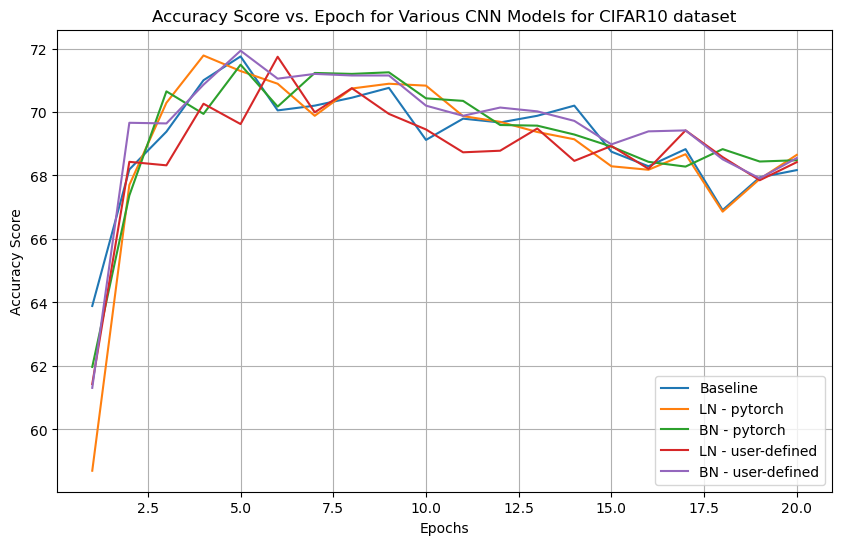

In [36]:

# Plot accuracy scores vs. epochs for each model
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot Model A
plt.plot(epochs, accu_cifar, label=model_names[0])

# Plot Model B
plt.plot(epochs, accu1_cifar, label=model_names[1])

# Plot Model C
plt.plot(epochs, accu2_cifar, label=model_names[2])

# Plot Model C
plt.plot(epochs, accu3_cifar, label=model_names[3])

# Plot Model C
plt.plot(epochs, accu4_cifar, label=model_names[4])

plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs. Epoch for Various CNN Models for CIFAR10 dataset")
plt.legend(loc="lower right")  # Adjust the legend position as needed

plt.grid(True)
plt.show()

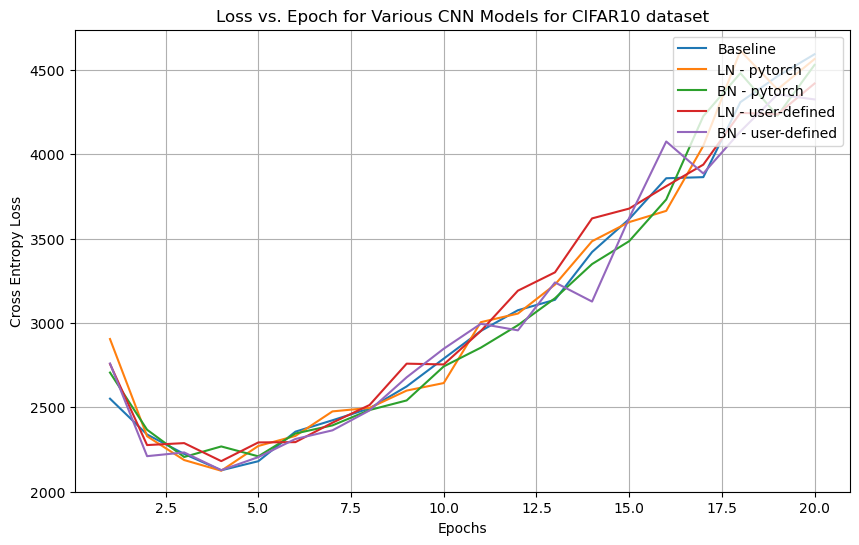

In [38]:
# Plot accuracy scores vs. epochs for each model
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot Model A
plt.plot(epochs, Loss_cifar, label=model_names[0])

# Plot Model B
plt.plot(epochs, Loss1_cifar, label=model_names[1])

# Plot Model C
plt.plot(epochs, Loss2_cifar, label=model_names[2])

# Plot Model C
plt.plot(epochs, Loss3_cifar, label=model_names[3])

# Plot Model C
plt.plot(epochs, Loss4_cifar, label=model_names[4])

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss vs. Epoch for Various CNN Models for CIFAR10 dataset")
plt.legend(loc="lower right")  # Adjust the legend position as needed

plt.grid(True)
plt.show()

#### Refrences
[1] 	Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift, arXiv preprint arXiv:1502.03167. </br>
[2] 	Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2018). How does batch normalization help optimization?, Advances in Neural Information Processing Systems . </br>
[3] 	Johann Huber(2020), Batch normalization in 3 levels of understanding, Towards Data Science. </br>
[4]	    Bala Priya C, Build Better Deep Learning Models with Batch and Layer Normalization, pinecone.io  </br>
[5]	    Ian Goodfellow, Ch 9: Convolutional Networks, Youtube. </br>
[6] 	Jimmy Lei Ba, Jamie Ryan Kiros, Geoffrey E. Hinton(2016), Layer Normalization, arXiv preprint arXiv:1607.06450. </br>
[7]	    Normalization, paperswithcode.com  </br>
[8]	    Yuxin Wu, Kaiming He (2018), Group Normalization, arXiv:1803.08494v3  </br>
[9] 	Elad Hoffer, , Itay Hubara, , Daniel Soudry (2018) ,Train longer, generalize better: closing the generalization gap in large batch training of neural networks, arXiv:1705.08741v2  </br>
[10]	Cecilia Summers, Michael J. Dinneen (2020), Four Things Everyone should know to improve Batch Normalization, arXiv:1906.03548v2   </br>

